In [1]:
hdf5_file = "/home/aloha/aloha_data/busybox_collection/data_session_2025-09-15_22.32.46/task_type/episode_0.hdf5"

In [3]:
import h5py


def print_hdf5_tree(file_path):
    def print_node(name, obj, level=0):
        indent = '│   ' * (level - 1) + ('├── ' if level > 0 else '') if level > 0 else ''
        node_type = 'Group' if isinstance(obj, h5py.Group) else 'Dataset'
        print(f"{indent}{name.split('/')[-1] if name else '/'} [{node_type}]")
        if isinstance(obj, h5py.Group):
            for key in obj:
                print_node(f"{name}/{key}" if name else key, obj[key], level + 1)
    with h5py.File(file_path, 'r') as f:
        print(f"HDF5 Structure for {file_path}:")
        print_node('', f, 0)


print_hdf5_tree(hdf5_file)

HDF5 Structure for /home/aloha/aloha_data/busybox_collection/data_session_2025-09-15_22.32.46/task_type/episode_0.hdf5:
/ [Group]
├── action [Dataset]
├── action_timestamp [Dataset]
├── base_action [Dataset]
├── busybox [Group]
│   ├── state_json [Dataset]
│   ├── timestamp [Dataset]
├── compress_len [Dataset]
├── observations [Group]
│   ├── effort [Dataset]
│   ├── images [Group]
│   │   ├── cam_high [Dataset]
│   │   ├── cam_left_wrist [Dataset]
│   │   ├── cam_right_wrist [Dataset]
│   ├── qpos [Dataset]
│   ├── qvel [Dataset]
│   ├── timestamp [Dataset]


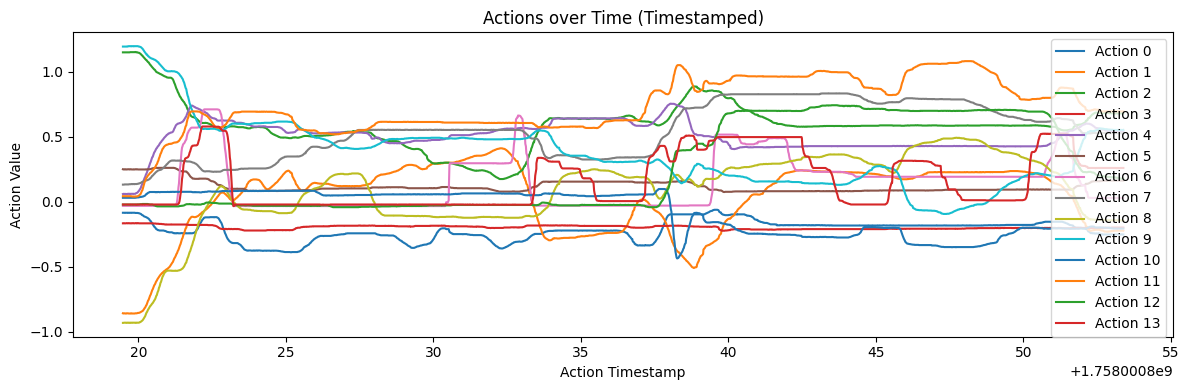

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

with h5py.File(hdf5_file, 'r') as f:
    def find_dataset_by_key(g, key_substr):
        for key in g:
            if key_substr in key.lower():
                return g[key]
            if isinstance(g[key], h5py.Group):
                result = find_dataset_by_key(g[key], key_substr)
                if result is not None:
                    return result
        return None
    actions_ds = find_dataset_by_key(f, 'action')
    timestamps_ds = find_dataset_by_key(f, 'timestamp')
    if actions_ds is None:
        raise ValueError("No dataset containing 'action' found in the HDF5 file.")
    if timestamps_ds is None:
        raise ValueError("No dataset containing 'timestamp' found in the HDF5 file.")
    actions = actions_ds[()]
    timestamps = timestamps_ds[()]

# Plot actions with timestamps
plt.figure(figsize=(12, 4))
if actions.ndim == 1:
    plt.plot(timestamps, actions, label='Action')
    plt.ylabel('Action Value')
else:
    for i in range(actions.shape[1]):
        plt.plot(timestamps, actions[:, i], label=f'Action {i}')
    plt.ylabel('Action Value')
plt.xlabel('Action Timestamp')
plt.title('Actions over Time (Timestamped)')
plt.legend()
plt.tight_layout()
plt.show()

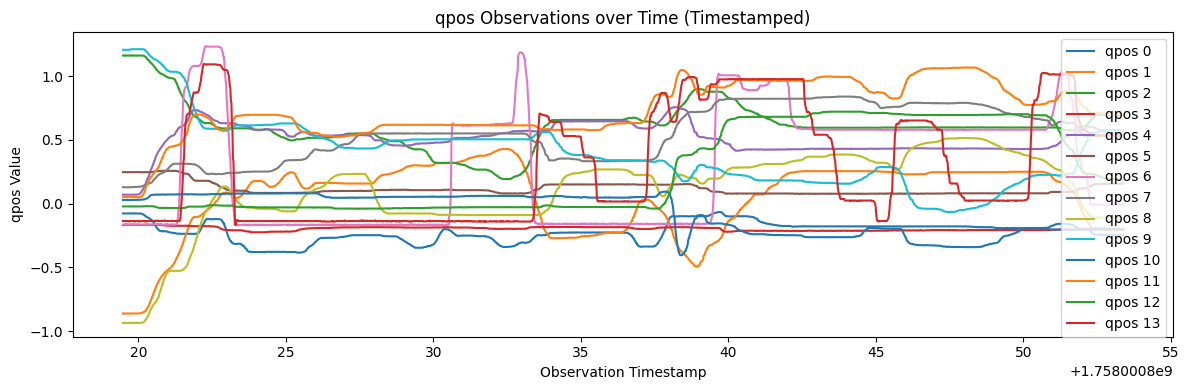

In [ ]:
import h5py
import json
from pprint import pprint

with h5py.File(hdf5_file, 'r') as f:
    def find_dataset_by_key(g, key_substr):
        for key in g:
            if key_substr in key.lower():
                return g[key]
            if isinstance(g[key], h5py.Group):
                result = find_dataset_by_key(g[key], key_substr)
                if result is not None:
                    return result
        return None
    state_json_ds = find_dataset_by_key(f, 'state_json')
    if state_json_ds is None:
        raise ValueError("No dataset containing 'state_json' found in the HDF5 file.")
    # Try to decode as utf-8 string if needed
    if hasattr(state_json_ds, 'asstr'):
        state_jsons = state_json_ds.asstr()[()]
    else:
        state_jsons = state_json_ds[()]
        if state_jsons.dtype.char == 'S':
            state_jsons = [s.decode('utf-8') for s in state_jsons]
    # Show the first state_json in detail
    first_state = json.loads(state_jsons[0])
    print("First busybox state_json:")
    pprint(first_state)
    print("\nKeys in state_json:", list(first_state.keys()))

In [9]:
import h5py, json, textwrap, itertools
from pprint import pprint

MAX_PRINT_WIDTH = 100
MAX_VALUE_PREVIEW = 120
SAMPLE_INDICES = (0,)
MAX_DEPTH = 3


def wrap(s, width=MAX_PRINT_WIDTH):
    return '\n'.join(textwrap.wrap(s, width=width))


def collect_candidate_json_datasets(h5file):
    candidates = []
    def visit(name, obj):
        if isinstance(obj, h5py.Dataset):
            lname = name.lower()
            if any(k in lname for k in ['state_json', 'state', 'busybox']):
                candidates.append(name)
    h5file.visititems(lambda n, o: visit(n, o))
    return candidates


def try_load_dataset_as_json(ds):
    try:
        data = ds.asstr()[()] if hasattr(ds, 'asstr') else ds[()]
        # Ensure iterable of entries
        if isinstance(data, (bytes, str)):
            data = [data]
        decoded = []
        for i, entry in enumerate(data[:50]):  # limit decode attempts
            if isinstance(entry, bytes):
                entry = entry.decode('utf-8', errors='ignore')
            entry = entry.strip()
            if not entry:
                continue
            try:
                decoded.append(json.loads(entry))
            except json.JSONDecodeError:
                return None  # Not JSON
        return decoded if decoded else None
    except Exception:
        return None


def describe_json_structure(obj, depth=0, max_depth=MAX_DEPTH):
    indent = '  ' * depth
    if depth > max_depth:
        print(f"{indent}... (max depth reached)")
        return
    if isinstance(obj, dict):
        print(f"{indent}dict with {len(obj)} keys")
        for k in sorted(obj.keys()):
            v = obj[k]
            t = type(v).__name__
            preview = ''
            if isinstance(v, (str, int, float, bool)):
                pv = str(v)
                if len(pv) > 40: pv = pv[:37] + '...'
                preview = f" = {pv}"
            elif isinstance(v, list):
                preview = f" (list[{len(v)}])"
            elif isinstance(v, dict):
                preview = f" (dict[{len(v)}])"
            print(f"{indent}  {k} : {t}{preview}")
            if isinstance(v, (dict, list)):
                describe_json_structure(v, depth+2, max_depth)
    elif isinstance(obj, list):
        print(f"{indent}list[{len(obj)}]")
        # show up to 3 representative elements
        for i, v in enumerate(itertools.islice(obj, 3)):
            print(f"{indent}  [{i}] : {type(v).__name__}")
            if isinstance(v, (dict, list)):
                describe_json_structure(v, depth+2, max_depth)
    else:
        print(f"{indent}{type(obj).__name__}: {obj}")


with h5py.File(hdf5_file, 'r') as f:
    candidates = collect_candidate_json_datasets(f)
    if not candidates:
        raise ValueError("No candidate state JSON datasets found (looked for names containing state_json/state/busybox)")
    print("Found candidate datasets:")
    for c in candidates:
        print("  -", c)

    # Pick the first one that actually decodes as JSON
    decoded_info = None
    chosen_path = None
    for path in candidates:
        ds = f[path]
        decoded = try_load_dataset_as_json(ds)
        if decoded is not None and decoded:
            decoded_info = decoded
            chosen_path = path
            break
    if decoded_info is None:
        raise ValueError("None of the candidate datasets decoded as JSON. Inspect dataset names above.")

    total_entries = f[chosen_path].shape[0] if len(f[chosen_path].shape) > 0 else 1
    print(f"\nUsing dataset: {chosen_path} (entries: {total_entries})")

    # Show sample indices (cap to dataset length)
    sample_idxs = sorted(set(i for i in SAMPLE_INDICES if i < total_entries))
    if not sample_idxs:
        sample_idxs = [0]

    # Reload full raw dataset for the selected indices
    raw_ds = f[chosen_path]
    samples = []
    for idx in sample_idxs:
        entry = raw_ds[idx]
        if isinstance(entry, bytes):
            entry = entry.decode('utf-8', errors='ignore')
        samples.append(entry)

print("\n=== Sample Raw JSON Entries ===")
for idx, raw in zip(sample_idxs, samples):
    raw_disp = raw if len(raw) < MAX_VALUE_PREVIEW else raw[:MAX_VALUE_PREVIEW] + '...'
    print(f"[index {idx}] len={len(raw)}")
    print(wrap(raw_disp))
    print('-'*60)

# Parse first JSON fully and describe structure
first_obj = json.loads(samples[0]) if samples else decoded_info[0]
print("\n=== Parsed Structure (first entry) ===")
describe_json_structure(first_obj)

# Extract flat numeric scalars across frames if possible
import math
flat_numeric = {}
if isinstance(first_obj, dict):
    keys = list(first_obj.keys())
    # We'll attempt to parse up to 200 entries (or all if fewer)
    limit = min(200, len(decoded_info))
    for k in keys:
        try:
            vals = []
            ok = True
            for obj in decoded_info[:limit]:
                v = obj.get(k)
                if isinstance(v, (int, float)) and not (isinstance(v, float) and (math.isnan(v) or math.isinf(v))):
                    vals.append(v)
                else:
                    ok = False
                    break
            if ok and vals:
                flat_numeric[k] = vals
        except Exception:
            pass

if flat_numeric:
    import pandas as pd
    df = pd.DataFrame(flat_numeric)
    print("\nFlat numeric scalar fields detected:")
    print(df.head())
else:
    print("\nNo simple repeating numeric scalar fields detected in first ~200 entries.")

Found candidate datasets:
  - busybox/state_json
  - busybox/timestamp

Using dataset: busybox/state_json (entries: 1801)

=== Sample Raw JSON Entries ===
[index 0] len=165
{"buttons": {"values": [1, 1, 1, 1]}, "knob": {"values": [22]}, "sliders": {"values": [899, 899]},
"switches": {"values"...
------------------------------------------------------------

=== Parsed Structure (first entry) ===
dict with 5 keys
  buttons : dict (dict[1])
    dict with 1 keys
      values : list (list[4])
        ... (max depth reached)
  knob : dict (dict[1])
    dict with 1 keys
      values : list (list[1])
        ... (max depth reached)
  sliders : dict (dict[1])
    dict with 1 keys
      values : list (list[2])
        ... (max depth reached)
  switches : dict (dict[1])
    dict with 1 keys
      values : list (list[2])
        ... (max depth reached)
  wires : dict (dict[1])
    dict with 1 keys
      values : list (list[4])
        ... (max depth reached)

No simple repeating numeric scalar fie

DataFrame columns: ['timestamp', 'button_0', 'button_1', 'button_2', 'button_3', 'knob_0', 'slider_0', 'slider_1', 'switch_0', 'switch_1', 'wire_0', 'wire_1', 'wire_2', 'wire_3']
   timestamp  button_0  button_1  button_2  button_3  knob_0  slider_0  \
0          0       1.0       1.0       1.0       1.0    22.0     899.0   
1          1       1.0       1.0       1.0       1.0    22.0     899.0   
2          2       1.0       1.0       1.0       1.0    22.0     899.0   
3          3       1.0       1.0       1.0       1.0    22.0     899.0   
4          4       1.0       1.0       1.0       1.0    22.0     899.0   

   slider_1  switch_0  switch_1  wire_0  wire_1  wire_2  wire_3  
0     899.0       0.0       0.0     0.0     0.0     0.0     0.0  
1     899.0       0.0       0.0     0.0     0.0     0.0     0.0  
2     899.0       0.0       0.0     0.0     0.0     0.0     0.0  
3     899.0       0.0       0.0     0.0     0.0     0.0     0.0  
4     899.0       0.0       0.0     0.0     0.

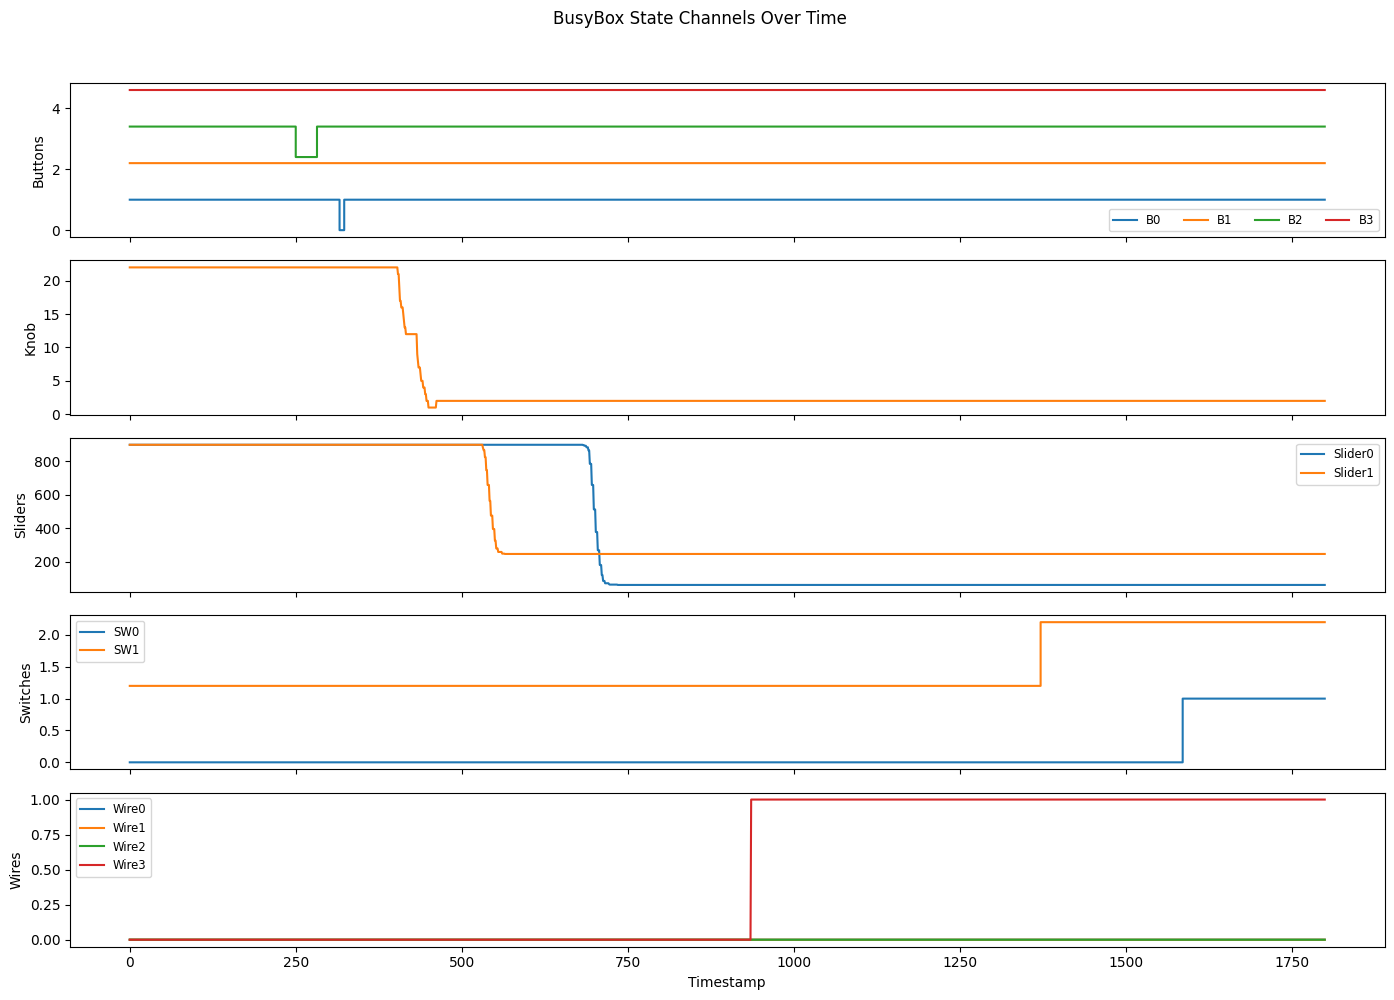

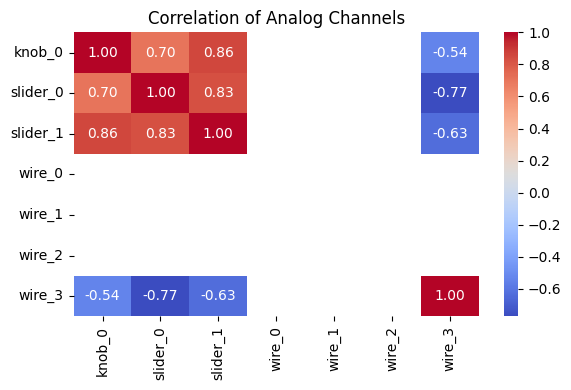

In [12]:
import h5py, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from itertools import zip_longest

# Plot parsed busybox modal sensor values over time
with h5py.File(hdf5_file, 'r') as f:
    state_ds = f['busybox/state_json']
    time_ds = f['busybox/timestamp'] if 'busybox/timestamp' in f['busybox'] else None
    if time_ds is not None:
        timestamps = time_ds[()]
    else:
        timestamps = np.arange(state_ds.shape[0])

    # Decode entries
    if hasattr(state_ds, 'asstr'):
        raw_entries = state_ds.asstr()[()]
    else:
        raw_entries = state_ds[()]
        raw_entries = [e.decode('utf-8', errors='ignore') if isinstance(e, bytes) else e for e in raw_entries]

# Parse JSON safely
parsed = []
for r in raw_entries:
    try:
        parsed.append(json.loads(r))
    except Exception:
        parsed.append({})

n = len(parsed)
# Helper to extract channel arrays
def extract_block(key):
    vals = []
    for obj in parsed:
        v = obj.get(key, {})
        if isinstance(v, dict):
            v = v.get('values', [])
        if not isinstance(v, (list, tuple)):
            v = [v]
        vals.append(v)
    # Determine max length
    max_len = max((len(v) for v in vals), default=0)
    # Pad with nan
    arr = np.full((n, max_len), np.nan, dtype=float)
    for i, v in enumerate(vals):
        for j, x in enumerate(v[:max_len]):
            try:
                arr[i, j] = float(x)
            except Exception:
                arr[i, j] = np.nan
    return arr

buttons = extract_block('buttons')  # shape (n,4?)
knob = extract_block('knob')        # shape (n,1?)
sliders = extract_block('sliders')  # shape (n,2?)
switches = extract_block('switches')# shape (n,2?)
wires = extract_block('wires')      # shape (n,4?)

# Build a tidy DataFrame for potential further analysis
series_dict = {}
for name, arr in [('button', buttons), ('knob', knob), ('slider', sliders), ('switch', switches), ('wire', wires)]:
    if arr.size == 0:
        continue
    for ch in range(arr.shape[1]):
        series_dict[f'{name}_{ch}'] = arr[:, ch]

df = pd.DataFrame(series_dict)
df.insert(0, 'timestamp', timestamps)
print('DataFrame columns:', df.columns.tolist())
print(df.head())

# Plotting
n_plots = 5
fig, axes = plt.subplots(n_plots, 1, figsize=(14, 2.0 * n_plots), sharex=True)
axes = np.atleast_1d(axes)

# 1 Buttons (discrete) - offset for clarity
if buttons.size:
    offset = 0
    for ch in range(buttons.shape[1]):
        axes[0].step(timestamps, buttons[:, ch] + offset, where='post', label=f'B{ch}')
        offset += 1.2
    axes[0].set_ylabel('Buttons')
    axes[0].legend(ncol=buttons.shape[1], fontsize='small')
else:
    axes[0].text(0.5, 0.5, 'No buttons', transform=axes[0].transAxes, ha='center')

# 2 Knob
if knob.size:
    axes[1].plot(timestamps, knob[:,0], label='Knob', color='tab:orange')
    axes[1].set_ylabel('Knob')
else:
    axes[1].text(0.5, 0.5, 'No knob', transform=axes[1].transAxes, ha='center')

# 3 Sliders
if sliders.size:
    for ch in range(sliders.shape[1]):
        axes[2].plot(timestamps, sliders[:, ch], label=f'Slider{ch}')
    axes[2].set_ylabel('Sliders')
    axes[2].legend(fontsize='small')
else:
    axes[2].text(0.5, 0.5, 'No sliders', transform=axes[2].transAxes, ha='center')

# 4 Switches (discrete) offset
if switches.size:
    offset = 0
    for ch in range(switches.shape[1]):
        axes[3].step(timestamps, switches[:, ch] + offset, where='post', label=f'SW{ch}')
        offset += 1.2
    axes[3].set_ylabel('Switches')
    axes[3].legend(fontsize='small')
else:
    axes[3].text(0.5, 0.5, 'No switches', transform=axes[3].transAxes, ha='center')

# 5 Wires
if wires.size:
    for ch in range(wires.shape[1]):
        axes[4].plot(timestamps, wires[:, ch], label=f'Wire{ch}')
    axes[4].set_ylabel('Wires')
    axes[4].legend(fontsize='small')
else:
    axes[4].text(0.5, 0.5, 'No wires', transform=axes[4].transAxes, ha='center')

axes[-1].set_xlabel('Timestamp')
fig.suptitle('BusyBox State Channels Over Time', y=0.995)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

# Optional: quick correlation heatmap of analog-like channels
analog_cols = [c for c in df.columns if any(prefix in c for prefix in ['knob', 'slider', 'wire'])]
if len(analog_cols) > 1:
    import seaborn as sns
    corr = df[analog_cols].corr(numeric_only=True)
    plt.figure(figsize=(6,4))
    sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
    plt.title('Correlation of Analog Channels')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough analog-like channels for correlation heatmap.')